In [ ]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from PIL import Image
import os


Libraries imported!


In [30]:
# Simple Transform Function
def simple_transform(image):
    """Apply basic preprocessing: resize + blur (keep as uint8)"""
    # Resize to standard size
    image = cv2.resize(image, (256, 256))
    
    # Apply Gaussian blur for noise reduction
    image = cv2.GaussianBlur(image, (5, 5), 0)
    
    return image

# Simple Dataset Class
class NucleiDataset:
    def __init__(self, data_path, transform=None):
        self.data_path = Path(data_path)
        self.transform = transform
        self.image_ids = [d.name for d in self.data_path.iterdir() if d.is_dir()]
        print(f"Found {len(self.image_ids)} images")
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        # Load image (grayscale)
        img_path = list((self.data_path / image_id / 'images').glob('*'))[0]
        image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        
        # Load masks
        mask_path = self.data_path / image_id / 'masks'
        if mask_path.exists():
            masks = [cv2.imread(str(m), cv2.IMREAD_GRAYSCALE) 
                    for m in mask_path.glob('*.png')]
            combined_mask = np.zeros_like(masks[0])
            for m in masks:
                combined_mask = np.maximum(combined_mask, m)
        else:
            combined_mask = None
        
        # Apply transform
        if self.transform:
            image = self.transform(image)
        
        return image, combined_mask, image_id

# Create datasets with transform
train_dataset = NucleiDataset('data/stage1_train', transform=simple_transform)
test_dataset = NucleiDataset('data/stage1_test', transform=simple_transform)

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Found 670 images
Found 65 images
Train: 670, Test: 65


Image shape: (256, 256)
Mask shape: (256, 320)
Image ID: ebc18868864ad075548cc1784f4f9a237bb98335f9645ee727dac8332a3e3716


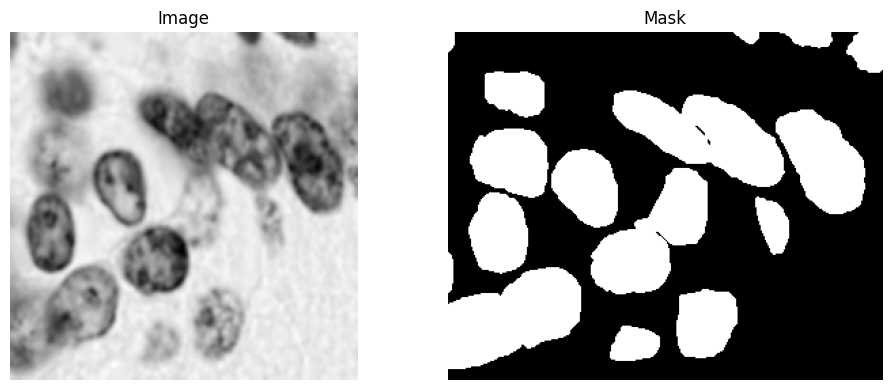

In [31]:
# Test Dataset
from random import randint

sample_idx = randint(0, len(train_dataset) - 1)
image, mask, image_id = train_dataset[sample_idx]

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape if mask is not None else None}")
print(f"Image ID: {image_id}")

# Visualize
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

In [32]:
# Watershed Implementation
from skimage.segmentation import watershed
from skimage import measure
from scipy import ndimage

def apply_watershed(image, use_markers=True):
    """Apply watershed segmentation"""
    # Threshold
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    if use_markers:
        # Distance transform
        dist = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
        
        # Sure foreground
        _, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)
        
        # Label markers
        markers = measure.label(sure_fg)
        
        # Watershed
        labels = watershed(-dist, markers, mask=binary)
    else:
        # No markers - naive
        markers = measure.label(binary)
        gradient = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, np.ones((3, 3)))
        labels = watershed(gradient, markers, mask=binary)
    
    return labels

# Test
labels_without = apply_watershed(image, use_markers=False)
labels_with = apply_watershed(image, use_markers=True)

print(f"Without markers: {labels_without.max()} regions")
print(f"With markers: {labels_with.max()} regions")

Without markers: 20 regions
With markers: 1 regions


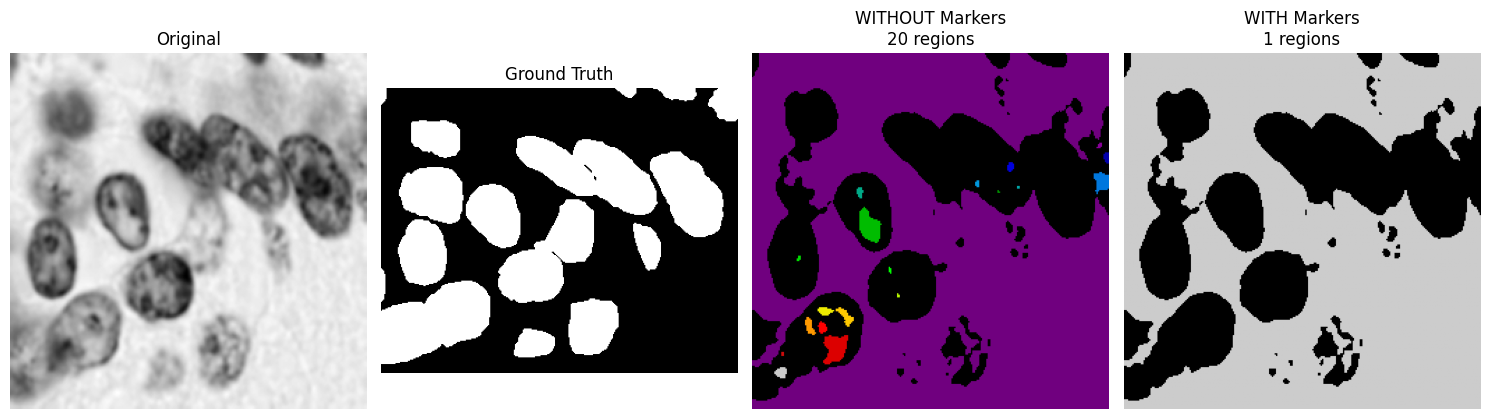

In [33]:
# Visualize Results
from skimage import color

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(mask, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(labels_without, cmap='nipy_spectral')
plt.title(f'WITHOUT Markers\n{labels_without.max()} regions')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(labels_with, cmap='nipy_spectral')
plt.title(f'WITH Markers\n{labels_with.max()} regions')
plt.axis('off')

plt.tight_layout()
plt.show()

## Output Directory: `stage1_test_seg`

This folder contains segmentations for all images from the **Data Science Bowl `stage1_test`** dataset.

**Structure:**
- Each subfolder is named exactly as the corresponding test image ID
- Each subfolder contains 2 segmentation files:
  - `with_marker.png` - Watershed segmentation using marker-controlled approach
  - `without_marker.png` - Naive watershed segmentation

In [34]:
# Generate Segmentations for All Test Images
output_dir = Path('stage1_test_seg')
output_dir.mkdir(exist_ok=True)

print(f"Processing {len(test_dataset)} test images...")
print(f"Output directory: {output_dir}")

for idx in range(len(test_dataset)):
    image, mask, image_id = test_dataset[idx]
    
    # Apply watershed with and without markers
    labels_without = apply_watershed(image, use_markers=False)
    labels_with = apply_watershed(image, use_markers=True)
    
    # Create subfolder for this image
    img_output_dir = output_dir / image_id
    img_output_dir.mkdir(exist_ok=True)
    
    # Save raw labels directly as uint8
    cv2.imwrite(str(img_output_dir / 'without_marker.png'), labels_without.astype(np.uint8))
    cv2.imwrite(str(img_output_dir / 'with_marker.png'), labels_with.astype(np.uint8))

print(f"\n✓ All segmentations saved to '{output_dir}'")

Processing 65 test images...
Output directory: stage1_test_seg

✓ All segmentations saved to 'stage1_test_seg'


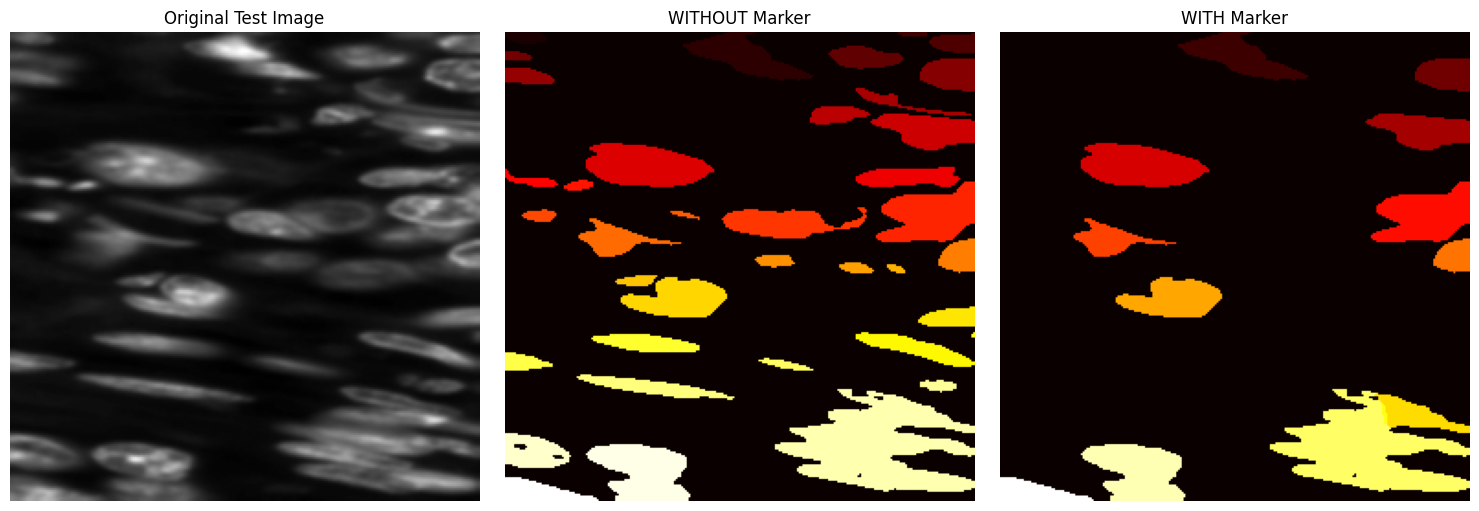

In [35]:
# Visualize Sample Segmentations
# Load and display a sample from the saved segmentations

sample_idx = randint(0, len(test_dataset) - 1)
sample_image, _, sample_id = test_dataset[sample_idx]

# Load the saved segmentations
seg_dir = Path('stage1_test_seg') / sample_id
seg_without = cv2.imread(str(seg_dir / 'without_marker.png'), cv2.IMREAD_GRAYSCALE)
seg_with = cv2.imread(str(seg_dir / 'with_marker.png'), cv2.IMREAD_GRAYSCALE)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(sample_image, cmap='gray')
axes[0].set_title('Original Test Image')
axes[0].axis('off')

axes[1].imshow(seg_without, cmap='hot')
axes[1].set_title(f'WITHOUT Marker')
axes[1].axis('off')

axes[2].imshow(seg_with, cmap='hot')
axes[2].set_title(f'WITH Marker')
axes[2].axis('off')
plt.tight_layout()
plt.show()
